# Live Well Dorset Referral Trend Analysis
Analysis of the Live Well Dorset referral data distribution density, GP / non GP disparity, and time seris trends components as part of a wider analysis of the effect of professional healthcare communication on GP referral rates. 
[Research project](https://andyist.github.io/mres/)

In [12]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings                     # `do not disturbe` mode              
warnings.filterwarnings('ignore')
from datetime import datetime

%run Livewell.ipynb # Project specific helpers 

#Load and prepare client data
clients = pd.read_csv("csv-data/18Jan2019/clients.csv", index_col='clientID', parse_dates=['DateRegistered','Date_registered_Month_Year'], dayfirst=True)
clients = prepare_clients(clients)


### 1. Display total referrals

In [27]:
print('Records before removal: ' + str(len(clients.index)))

Records before removal: 19595


### 2. Plot monthly distribution - all referrals

Text(0,0.5,'n Referrals')

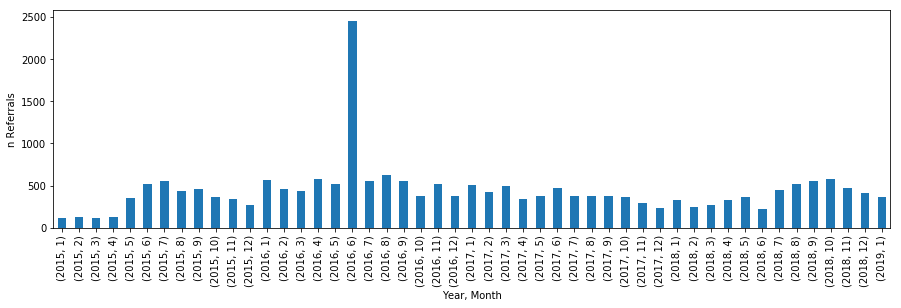

In [13]:
dates = clients[['DateRegistered','gp_referral']]
months = dates[['DateRegistered']].groupby([dates["DateRegistered"].dt.year, dates["DateRegistered"].dt.month]).count()
months.rename(columns = {'DateRegistered': 'Referrals'}, inplace=True)
ax = months.plot(kind="bar", figsize=(15,4), legend=False)
ax.set_xlabel("Year, Month")
ax.set_ylabel("n Referrals")

### 3. Remove anomolous data (records imported spike in 2 minute period June 2016) 

In [14]:
clients = clients.loc[~clients.DateRegistered.isin(['2016-06-15 17:03:00','2016-06-15 17:04:00'])]
print('Records after removal: ' + str(len(clients.index)))

Records before: 21524
Records after: 19595


### 4. Remove the time component from the date stamps (we are not interested in greater than daily resolutions)

In [15]:
clients = clients.assign(DateRegistered=clients.DateRegistered.dt.round('D'))
# Output the first and last time stamps of the dataset
clients['DateRegistered'].min(), clients['DateRegistered'].max()

(Timestamp('2015-01-06 00:00:00'), Timestamp('2019-01-13 00:00:00'))

### 5. Re-plot monthly distribution of registrations

Text(0,0.5,'n Referrals')

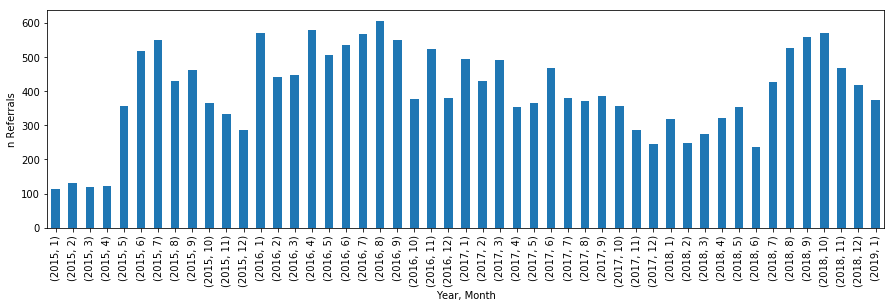

In [32]:
dates = clients[['DateRegistered','gp_referral']]
months = dates[['DateRegistered']].groupby([dates["DateRegistered"].dt.year, dates["DateRegistered"].dt.month]).count()
months.rename(columns = {'DateRegistered': 'Referrals'}, inplace=True)
ax = months.plot(kind="bar", figsize=(15,4), legend=False)
ax.set_xlabel("Year, Month")
ax.set_ylabel("n Referrals")

### 6. Split gp_referral into boolean columns with daily count date index

In [33]:
gp_dates = dates.copy()
gp_dates['gp_referral'] = gp_dates['gp_referral'].astype(str)
dum = gp_dates.gp_referral.str.get_dummies().astype(bool)
gp_dates = pd.concat([gp_dates, dum], axis=1)
gp_dates.rename(columns = {'0': 'Non GP', '1': 'GP'}, inplace=True)
# Group by date counting referrals
gp_date_counts = gp_dates.groupby('DateRegistered').sum()
gp_date_counts = gp_date_counts.reset_index()
gp_date_counts.head()

,DateRegistered,Non GP,GP
0,2015-01-06,20.0,1.0
1,2015-01-07,21.0,0.0
2,2015-01-09,35.0,2.0
3,2015-01-10,25.0,0.0
4,2015-01-12,2.0,2.0


### 7. Plot time series of referrals split by GP and non GP

<Figure size 1080x360 with 0 Axes>

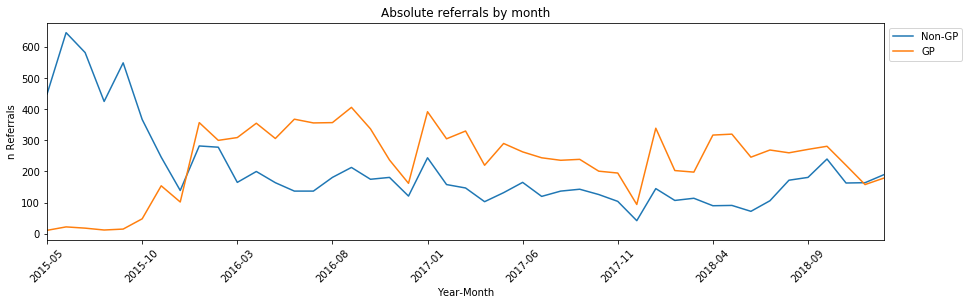

In [34]:
series = clients[['YearMonth','gp_referral','gp_surgery']]
series = series.pivot_table(index='YearMonth', columns='gp_referral', values='gp_surgery', aggfunc='count').reset_index()
# Setup and plot distribution
plt.figure().suptitle('Absolute referrals by month', fontsize=16)
ax = series.plot(x="YearMonth", y=[0, 1], kind="line", figsize=(15,4), title='Absolute referrals by month')
ax.set_xlabel("Year-Month")
ax.set_ylabel("n Referrals")
plt.xticks(rotation=45)
plt.legend(['Non-GP', 'GP'], loc='upper left',bbox_to_anchor=(1, 1))

### 8. Drop dispirate 2015 records (not reflective of subsiquent series)

In [36]:
print('Records before: ' + str(len(clients.index)))
series = clients.loc[clients.DateRegistered >= '2016-01-01 00:00:00'][['YearMonth','gp_referral','gp_surgery']]
gp_date_counts = gp_date_counts.loc[gp_date_counts.DateRegistered >= '2016-01-01 00:00:00']
print('Records (months) after: ' + str(len(series.index)) + ' (GPs ' + str(len(series.loc[series.gp_referral == 1])) +  ')')
series = series.pivot_table(index='YearMonth', columns='gp_referral', values='gp_surgery', aggfunc='count').reset_index()

Records before: 19595
Records (months) after: 15810 (GPs 10120)


### 7. Plot reduced time series of referrals split by GP and non GP including variation magnitude

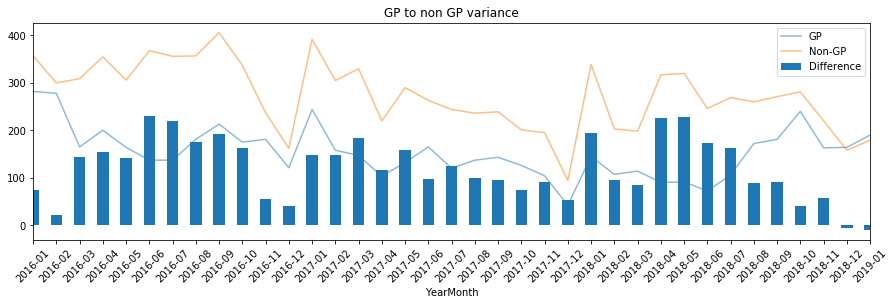

In [38]:
series['diff'] = series[1] - series[0]
fig,ax= plt.subplots()
series.plot(x="YearMonth", y=['diff'], ax=ax, kind="bar", figsize=(15,4), title='GP to non GP variance')
series.plot(x="YearMonth", y=[0,1], ax=ax, kind="line", figsize=(15,4), title='GP to non GP variance', alpha=0.5)
plt.xticks(rotation=45)
plt.legend(['GP', 'Non-GP', 'Difference'])

### 8. Plot trend decomposition of the GP referal rate timeseries

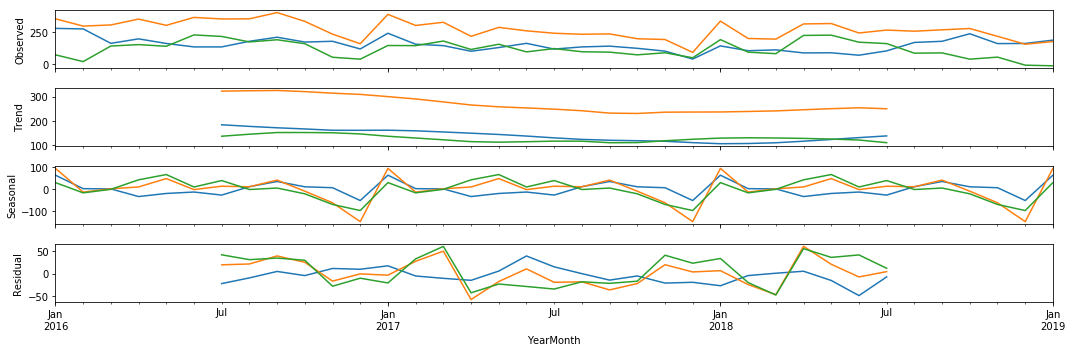

In [23]:
# Prepare time series for decomposition
decomp = series.copy()
decomp = decomp.set_index('YearMonth')
decomp.index = pd.to_datetime(decomp.index)
decomp = decomp.resample('M').mean()
# Time-series decomposition
# https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
rcParams['figure.figsize'] = 15, 5
decomposition = sm.tsa.seasonal_decompose(decomp, model='additive')
fig = decomposition.plot()
plt.show()

### 9. Plot trend decomposition of reduced GP referal rate timeseries

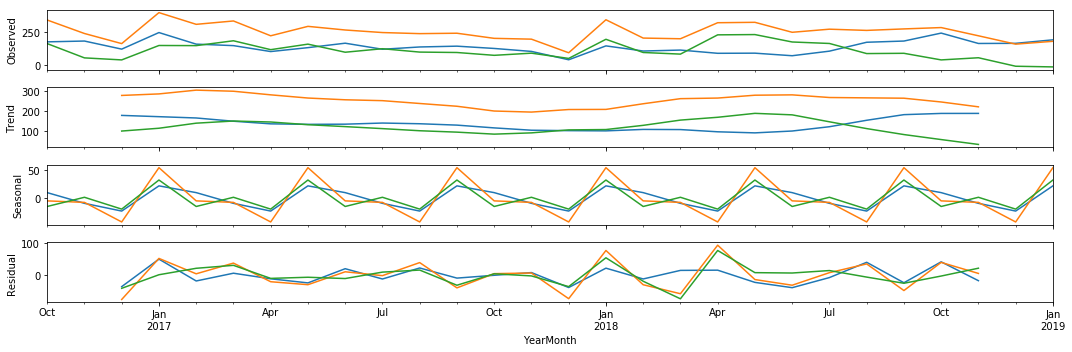

In [40]:
ydecomp = decomp.loc[decomp.index > '2016-10-01']
rcParams['figure.figsize'] = 15, 5
decomposition = sm.tsa.seasonal_decompose(ydecomp, model='additive', freq=4)
fig = decomposition.plot()
plt.show()